In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, decimate

In [ ]:
# ===== SESSION SELECTION =====
SESSION = "a3"         # animal id
STIM = "pinch_contra"  # stim type
# =============================

# Load table (prefer local override if present)
table_path = Path("data/sessions_local.csv") if Path("data/sessions_local.csv").exists() else Path("data/sessions.csv")
sessions = pd.read_csv(table_path, sep='\t')  # your CSV is tab-delimited

# Select row by session + stim
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]
if row.empty:
    raise ValueError(f"No row found for session={SESSION}, stim={STIM}")

row = row.iloc[0]

# Extract paths and metadata
phy_dir = Path(row['phy_dir']) if pd.notna(row['phy_dir']) and row['phy_dir'].strip() else None
ap_dir  = Path(row['ap_dir']) if pd.notna(row['ap_dir']) and row['ap_dir'].strip() else None
age = str(row['age']).strip() if pd.notna(row['age']) else "unknown"
notes = str(row['notes']).strip() if pd.notna(row['notes']) else ""

# Anatomy bands
S1_upper_um  = float(row['s1_upper_um'])
S1_lower_um  = float(row['s1_lower_um'])
VPL_upper_um = float(row['vpl_upper_um'])
VPL_lower_um = float(row['vpl_lower_um'])

# Optional: mid-depths for LFP channel picking
s1_mid_um  = (S1_upper_um + S1_lower_um) / 2.0
vpl_mid_um = (VPL_upper_um + VPL_lower_um) / 2.0

# Sanity check
if phy_dir is None or not phy_dir.exists():
    print(f"⚠️ Warning: phy_dir not found or empty for {SESSION}/{STIM}. Check paths or notes: '{notes}'")
if ap_dir is None or not ap_dir.exists():
    print(f"⚠️ Warning: ap_dir not found or empty for {SESSION}/{STIM}. Check paths.")

print(f"Loaded: {SESSION} / {STIM} (age: {age})")
print(f"Notes: {notes}")
print(f"phy_dir: {phy_dir}")
print(f"ap_dir:  {ap_dir}")


Loaded: a3 / pinch_contra (age: adult)
Notes: Sprase?
phy_dir: C:\Users\Ben\Desktop\Contra Pinch\A3
ap_dir:  E:\Neurpixels_Sally\practice3_SZMB_jawpinch_contra_final_2024-11-21_16-13-07\Record Node 118\experiment1\recording1\continuous\Neuropix-PXI-117.ProbeA-AP


In [ ]:
# Parameters
t0, twin = 0.0, None  # Time window in seconds, none for full
select_by = "depth"   # "depth" or "index"
max_ch = None   # set to an int (e.g., 192) to cap plotted channels
bp_lo, bp_hi = 1, 100
gain = 20.0     # LFP gain per channel (adjust as needed)


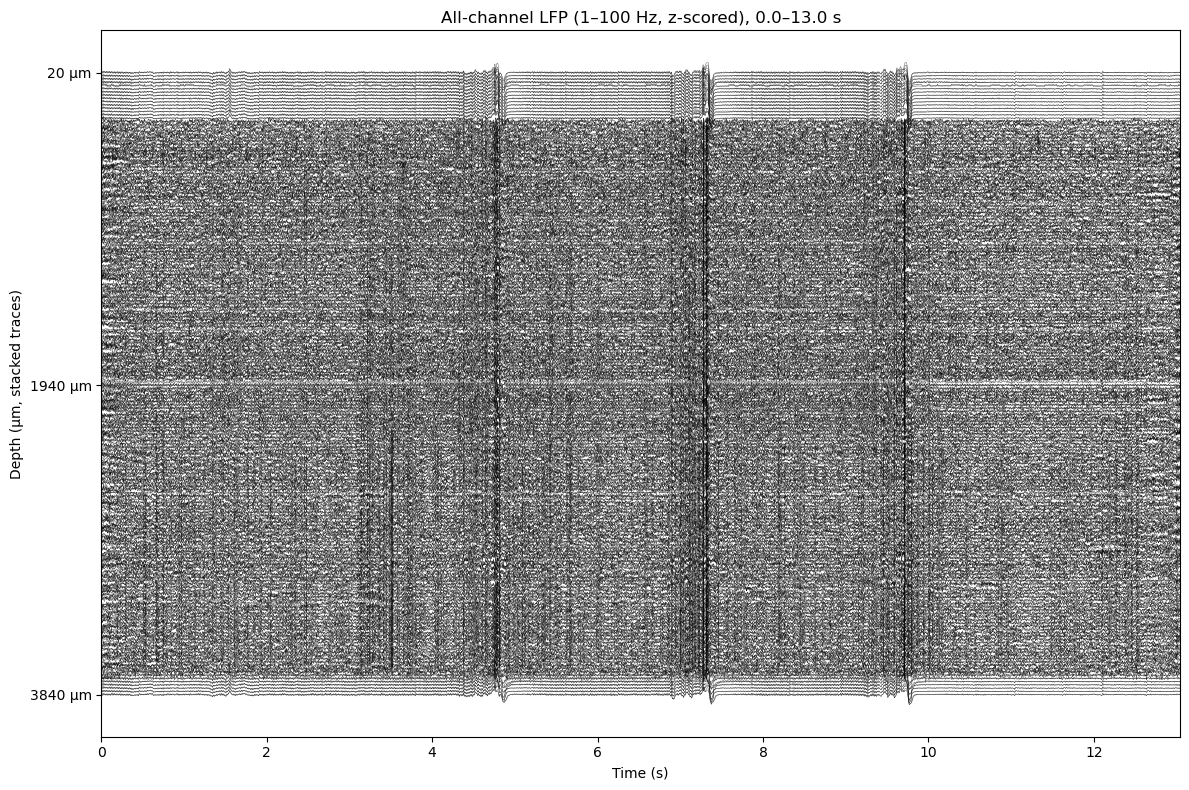

In [6]:
# ---- spike zero for clock anchoring ----
spike_times = np.load(phy_dir/'spike_times.npy')
spike_fs = 30000.0
try:
    txt = (phy_dir/'params.py').read_text()
    for line in txt.splitlines():
        if 'sample_rate' in line and '=' in line:
            spike_fs = float(line.split('=')[-1]); break
except Exception:
    pass
spike_zero = float(spike_times.min()/spike_fs)

# ---- derive LFP from AP, align to spike zero ----
sn_ap = np.load(ap_dir/'sample_numbers.npy')
n_samples_ap = sn_ap.size
bytes_total_ap = (ap_dir/'continuous.dat').stat().st_size
n_channels_ap = bytes_total_ap // (n_samples_ap*2)     # int16 -> 2 bytes
mm_ap = np.memmap(ap_dir/'continuous.dat', dtype='int16', mode='r')
ap = np.reshape(mm_ap, (n_samples_ap, n_channels_ap)).astype('float32')

fs_ap = 30000.0
# low-pass to 300 Hz, then decimate ×30 (~1 kHz)
b, a = butter(3, 300.0/(fs_ap/2), btype='low')
ap_lp = filtfilt(b, a, ap, axis=0)
dec = 30
lfp = decimate(ap_lp, dec, axis=0, ftype='fir', zero_phase=True)
t_lfp = (sn_ap.astype(float)/fs_ap)[::dec][:lfp.shape[0]]

# align to spike zero so LFP clock starts with Phy
t_lfp -= float(t_lfp[0])
t_lfp += spike_zero

# ---- pick channels and ordering by depth ----
chan_pos = np.load(phy_dir/'channel_positions.npy')  # (n_channels_ap, 2)
depths = chan_pos[:,1]
order = np.argsort(depths)                           # shallow -> deep
if max_ch is not None:
    # subsample channels uniformly by depth if too many
    step = max(1, len(order)//max_ch)
    order = order[::step]

# ---- select time window on aligned LFP ----
if twin is None:
    twin = float(t_lfp[-1] - t_lfp[0])

t1 = t0 + twin
sel_t = (t_lfp >= t0) & (t_lfp <= t1)
if not np.any(sel_t):
    raise RuntimeError(f"No LFP samples in window {t0:.2f}–{t1:.2f} s. Check t0/twin.")
t = t_lfp[sel_t]
X = lfp[sel_t][:, order]

# ---- display band-pass and z-score per channel ----
def bandpass(x, fs, lo=bp_lo, hi=bp_hi, order=3):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)
fs_disp = 1000.0  # ~1 kHz after decimation
try:
    Xb = bandpass(X, fs_disp, bp_lo, bp_hi, order=3)
except Exception:
    Xb = X

def zscore2D(M):
    m = np.median(M, axis=0, keepdims=True)
    s = np.std(M, axis=0, keepdims=True)
    s[s==0] = 1.0
    return (M - m) / s
Z = zscore2D(Xb)

# ---- stack and plot: offset by depth (µm) to make a depth map ----
depths_sel = depths[order]
# normalize depth range to a neat spacing (e.g., 40 units per 200 µm)
dmin, dmax = float(np.nanmin(depths_sel)), float(np.nanmax(depths_sel))
depth_norm = (depths_sel - dmin) / max(1.0, (dmax - dmin))
offsets = depth_norm * 10000.0    # vertical span for all channels                   
Y = Z * gain + offsets  # stacked signals

plt.figure(figsize=(12, 8))
plt.plot(t, Y, color='k', linewidth=0.3, alpha=0.7)
plt.xlim(t0, t1)
yticks_pos = [offsets[0], offsets[len(offsets)//2], offsets[-1]]
yticks_lab = [f"{int(depths_sel[0])} µm", f"{int(depths_sel[len(offsets)//2])} µm", f"{int(depths_sel[-1])} µm"]
plt.yticks(yticks_pos, yticks_lab)
plt.xlabel("Time (s)")
plt.ylabel("Depth (µm, stacked traces)")
plt.title(f"All-channel LFP (1–100 Hz, z‑scored), {t0:.1f}–{t1:.1f} s")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
